# Tutorial 25: unyt and gvar

## PHYS 2600, Spring 2019

In [2]:
# Import cell
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import gvar as gv
import unyt as u


## T25.1 - Basics of unyt

### Part A

Let's start with some basics of `unyt`, which I've imported under the alias `u` above.  Carry out the following exercises in the cell below - I've given you the shorthand names for the units, which you can access as `u.<name>`.

* Convert 5328 feet (`ft`) (Boulder's elevation) to kilometers (`km`).  (Should be about 1.6 km.)
* Compute the total power in watts (`W`) delivered by a 8000 watt (`W`) generator and a 300 horsepower (`hp`) car.  (Should be about 232k watts.)
* Find the force in Newtons (`N`) required to accelerate a 10-pound (`lb`) weight to a speed of 3 feet (`ft`) per second (`s`) squared in 4 seconds.  (Should be about 1 Newton.)

By default, your answers will print out with lots of digits.  Individual `unyt` objects can be printed with ordinary string format codes like `%g` - __try it out__!  (Note that this will just give the number and not the unit, though.  The `.format()` method, which is [an alternative to the `%` format operator](https://www.geeksforgeeks.org/python-format-function/), will give units as well, but we haven't learned how to use that.)


In [3]:
### BEGIN SOLUTION
elev = 5328*u.ft
print(elev.to('km'))

total_pow = 8000*u.W + 300*u.hp
print(total_pow)
print('%g' % total_pow)

# a = delta v / delta t
accel = (3 * u.ft / u.s) / (4 * u.s)

# F = m * a
force = 10*u.lb * accel
print(force.to('N'))
### END SOLUTION

1.6239744000000003 km
231709.96147468107 W
231710
1.0369121578200002 N


### Part B

Below is an array containing the radii of all eight planets in the Solar system in kilometers:

In [4]:
# Radii of planets: Mercury, Venus, Earth, Mars, Jupiter, Saturn, Uranus, Neptune
# This is a list, but Unyt will automatically convert to an array
planet_radii = [2440, 6050, 6378, 3400, 71490, 60270, 25560, 24770] * u.km

The gravitational acceleration $g_P$ on the surface of planet $P$ is given by the standard formula,

$$
g_P = \frac{GM_P}{R_P^2}.
$$

Use the built-in physical constants from `unyt.physical_constants` ([listed here](https://unyt.readthedocs.io/en/latest/modules/unyt.physical_constants.html)) to __find $g_P$ for each of the eight planets__.  (To save lots of typing, you may want to import `unyt.physical_constants` with a shorter alias!)  Use `.in_mks()` to convert your results to m/s^2.



In [5]:
### BEGIN SOLUTION
import unyt.physical_constants as pc

# This is a list, but Unyt will automatically convert to an array
planet_masses = [pc.mass_mercury, pc.mass_venus, pc.mass_earth-0.07e24*u.kg, pc.mass_mars, 
                 pc.mass_jupiter, pc.mass_saturn, pc.mass_uranus, pc.mass_neptune]

planet_g = pc.gravitational_constant * planet_masses / planet_radii**2
print(planet_g.in_mks())
### END SOLUTION

[ 3.70038773  8.8747268   9.80373386  3.70462729 24.79140604 10.44415924
  8.86889098 11.14179963] m/s**2


Your answer for the familiar $g$ on Earth may look slightly funny.  What is the value of the Earth's mass used by `unyt`?  What is the value if you search for another source on the internet?  The Moon weighs about 0.07e24 kg...can you go back and fix up your array to get the correct $g$?  (There's an important moral here about trusting numbers you get from someone else's code...trust, but verify!)

## T25.2 - Basics of gvar

### Part A

Let's start with just making `gvar`s and doing simple arithmetic on them.  Enter the following values as `gvar` objects:

* x = 2.19(52)
* y = 0.93(13)

Try using both the string and numeric mean/error versions of `gv.gvar()`.

In [6]:
### BEGIN SOLUTION
x = gv.gvar('2.19(52)')
print(x)

y = gv.gvar(0.93, 0.13)
print(y)
### END SOLUTION

2.19(52)
0.93(13)


Now, calculate the following quantities:

* $w = x+y$
* $z = xy$


Verify that the propagation of error matches what you would expect from the analytic formulas:

$$
\sigma_{w} = \sqrt{\sigma_x^2 + \sigma_y^2} \\
\frac{\sigma_{z}}{z} = \sqrt{\frac{\sigma_x^2}{x^2} + \frac{\sigma_y^2}{y^2}}
$$

In [7]:
### BEGIN SOLUTION
w = x+y
print(w)

# Checking error propagation
print(w.sdev)
print(np.sqrt(x.sdev**2 + y.sdev**2))

z = x*y
print(z)

print(z.sdev)
print(z.mean * np.sqrt( (x.sdev / x.mean)**2 + (y.sdev / y.mean)**2 ) )

### END SOLUTION

3.12(54)
0.5360037313302959
0.5360037313302959
2.04(56)
0.5611800513204296
0.5611800513204297


### Part B

Use `gv.corr()` to find the _correlation coefficient_ between `w` and `z` - it should be non-zero since they were both produced from the same Gaussian variables, `x` and `y`!

Calculate the ratio `w/z`.  Then create two _brand new_ `gvar` variables, `w_new` and `z_new`, which have the same mean and error values as `w` and `z`.  Show that `w_new/z_new` has a much larger error bar than `w/z`, due to the missing correlations.

In [8]:
### BEGIN SOLUTION
print(gv.corr(w,z))

print(w/z)
w_new = gv.gvar('3.12(54)')
z_new = gv.gvar('2.04(56)')
print(w_new / z_new)
### END SOLUTION

0.959069739296225
1.53(19)
1.53(50)


## T25.3 - Units and errors at the same time

We're doing a photoelectric effect experiment, shining light of various frequencies onto a metallic plate with unknown work function $\Phi$.)  To begin with, we shine a blue light with wavelength $\lambda = 450$ nm, and adjust the reverse bias voltage until the current stops flowing in our experiment.  Measuring this "stopping voltage" allows us to determine the work function using the relation

$$
\Phi = \frac{hc}{\lambda} + eV_{\rm stop}
$$
where $h$ is Planck's constant, $c$ is the speed of light, and $e$ is the electron charge.

### Part A

The array below contains several measurements of $V_{\rm stop}$.  __Use `gv.dataset.avg_data()` to convert this to a number with an error bar.__

In [9]:
Vstop_meas = [0.60518702, 0.5607348 , 0.61921547, 0.43181751, 0.50939128,
              0.48633646, 0.46718925, 0.70914269, 0.63411835, 0.35302378,
              0.488022  , 0.49327817, 0.46512054, 0.56364097, 0.54846636,
              0.7839588 , 0.58187662, 0.58690202, 0.53403152, 0.7447812 ,
              0.59683929, 0.4711659 , 0.4399897 , 0.53631919, 0.3376564 ,
              0.80877011, 0.63026838, 0.76659314, 0.47598293, 0.78977753]

### BEGIN SOLUTION
Vstop = gv.dataset.avg_data(Vstop_meas)
print(Vstop)
### END SOLUTION

0.567(22)


Now we'd like to find a result for the work function $\Phi$ with an error bar.  Unfortunately, `unyt` and `gvar` don't play nicely together!  To find the answer, go through the following steps in the cell below:

1. Break the `gvar` you create for $V_{\rm stop}$ into separate variables for the mean and error bar, using the `.mean` and `.sdev` properties.
2. Add units (volts) to the mean and error variables, multiply by the electron charge
3. Calculate the photon energy $hc/\lambda$, add to $eV_{\rm stop}$ (just the mean, the error is not affected by adding a constant.)
4. Use `.to_value()` to convert the mean and error to their values in electron-volts, and combine them back into a final `gvar` for the work function `Phi`.

To get you started I've imported all the constants you'll need from `unyt.physical_constants`, and gave you the wavelength of incident light with units.

In [10]:
from unyt.physical_constants import electron_charge, planck_constant, c

lmb = 450 * u.nm

### BEGIN SOLUTION
Vs_mean, Vs_err = Vstop.mean, Vstop.sdev
eVs_mean, eVs_err = electron_charge * Vs_mean * u.V, electron_charge * Vs_err * u.V
print(eVs_mean.to('eV'), eVs_err.to('eV'))

E_photon = planck_constant * c / lmb
print(E_photon.to('eV'))

Phi_mean, Phi_err = E_photon + eVs_mean, eVs_err

Phi = gv.gvar(Phi_mean.to_value('eV'), Phi_err.to_value('eV'))
print(Phi)
### END SOLUTION


-0.5673199334873499 eV -0.02249738905376702 eV
2.7552042922710354 eV
2.188(22)


In this case, the error propagation was simple in the middle of our formula, so we just did it by hand.  Another approach would have been to convert $hc/\lambda$ and $eV$ to numbers in electron-volts with `unyt.to_value()` first, make them into _separate_ `gvar`s, and then add them together. 

### Part B

Now that we know $\Phi$, we can run the experiment backwards: if we know the stopping voltage and $\Phi$, we can determine the maximum wavelength of light $\lambda$ which will cause a current to flow.  Inverting the equation above gives

$$
\lambda = \frac{hc}{\Phi - eV_{\rm stop}}.
$$

Suppose we consider reverse voltages in the range from 0.5V to 1.5V, stepping by 0.1V, and the work function $\Phi$ is what we found above in part B.  __Make an array of `gvar`s__ containing the wavelength of light $\lambda$ (__in nm__) corresponding to each stopping voltage.

_(Hint: this time we need the error propagation!  You could use gvar to calculate_ $1/(\Phi - eV_{\rm stop})$, _and then multiply by $hc$ and units afterwards.  Or, you could convert $hc$ itself to a number with_ `to_value()`, _and then divide by the `gvar` array - but make sure you pick the right units!)_

In [11]:
volts = np.arange(0.5, 1.5, 0.1)

### BEGIN SOLUTION
E_gamma = Phi - volts
print(E_gamma)

wavelengths = (planck_constant * c).to_value('nm * eV') / E_gamma
print(wavelengths)
### END SOLUTION


[1.688(22) 1.588(22) 1.488(22) 1.388(22) 1.288(22) 1.188(22) 1.088(22)
 0.988(22) 0.888(22) 0.788(22)]
[734.6(9.8) 781(11) 833(13) 893(14) 963(17) 1044(20) 1140(24) 1255(29)
 1396(35) 1574(45)]


One more thing: now that we're working with numbers that have error bars, it would be nice to be able to _plot_ them!  Pyplot has us covered with the `plt.errorbar()` function.  The simplest way to use `plt.errorbar()` requires us to give _three_ arrays of the same length: `x`, `y`, and `yerr`.  Pyplot _also_ has no idea what a `gvar` is, so you'll need to use `.mean` and `.sdev` to get the arrays you need.

__Try to make an error-bar plot of your array of wavelengths__ in the cell below.  (I recommend turning on some sort of `marker` and setting `linestyle=' '` for a conventional-looking data plot.)

Text(0, 0.5, '$\\lambda$')

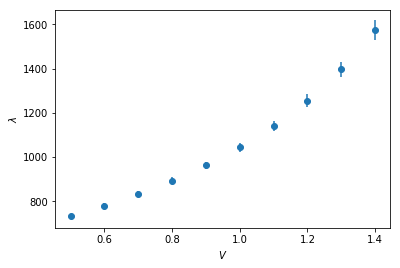

In [12]:
### BEGIN SOLUTION
plt.errorbar(volts, gv.mean(wavelengths), yerr=gv.sdev(wavelengths), marker='o', linestyle=' ')
plt.xlabel('$V$')
plt.ylabel('$\lambda$')
### END SOLUTION

### Bonus challenge

Can you use `unyt` to verify that XKCD comic from the start of my lecture?  (The Planck energy is equal to $1.22 \times 10^{28}$ eV; the comic is from January 2010, and the combined EPA mileage of the 2009 Toyota Prius was [46 miles per gallon](https://www.fueleconomy.gov/feg/noframes/25987.shtml).  Gallons aren't included in `unyt`, but you can use `u.define_unit` to add it yourself!)

In [13]:
u.define_unit("gallon", 0.00378541 * u.m**3)  

E_planck = 1.22e28 * u.eV
P_core = 360e9 * u.Pa
prius_mileage = 46 * u.mile / u.gallon
width_channel = 33.3 * u.km

((E_planck / P_core)*(prius_mileage / width_channel)).in_mks()



unyt_quantity(3.18872644, '(dimensionless)')